# Feature Engineering for Car Shipment Delay Classification

### This notebook prepares the cleaned car parts dataset with engineered features for building a classification model that predicts whether a car shipment will be delayed or not.  
The focus is on creating features that reflect real-world supply chain constraints and business impact.

In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Step 2: Load Cleaned Dataset
df_class=pd.read_csv("Cleaned_car_automated_dataset_final.csv")

In [ ]:
df_class.shape

(1010, 60)

In [ ]:
# View Available Columns
df_class.columns

Index(['Car_ID', 'Scheduled_Assembly_Date', 'Engine_Delivery_Date',
       'Engine_Supplier_Region', 'Engine_Transport_Mode', 'Is_Critical_Engine',
       'Transmission_Delivery_Date', 'Transmission_Supplier_Region',
       'Transmission_Transport_Mode', 'Is_Critical_Transmission',
       'Brake_System_Delivery_Date', 'Brake_System_Supplier_Region',
       'Brake_System_Transport_Mode', 'Is_Critical_Brake_System',
       'Suspension_Delivery_Date', 'Suspension_Supplier_Region',
       'Suspension_Transport_Mode', 'Is_Critical_Suspension',
       'Infotainment_Delivery_Date', 'Infotainment_Supplier_Region',
       'Infotainment_Transport_Mode', 'Is_Critical_Infotainment',
       'Car_Delayed', 'Delay_Days', 'Financial_Impact_USD',
       'Engine_Delayed_Flag', 'Transmission_Delayed_Flag',
       'Brake_System_Delayed_Flag', 'Suspension_Delayed_Flag',
       'Infotainment_Delayed_Flag', 'Any_Critical_Part_Delayed',
       'Engine_Delay_Reason', 'Transmission_Delay_Reason',
       'Brake_

In [ ]:
# Step 3: Convert Assembly Date to Datetime and Extract Temporal Features
df_class["Scheduled_Assembly_Date"]= pd.to_datetime(df_class["Scheduled_Assembly_Date"])

In [ ]:
# Extracting month and quarter of scheduled shipment for seasonal patterns
df_class['Month_Scheduled'] = df_class['Scheduled_Assembly_Date'].dt.month
df_class['Quarter_Scheduled'] = df_class['Scheduled_Assembly_Date'].dt.quarter

The exact Scheduled Assembly Date provides highly granular information that can be noisy and less effective for modeling temporal patterns. To capture meaningful seasonality and trends in shipment delays, we extract:

- Month of Scheduled Shipment (Month_Scheduled)

- Quarter of Scheduled Shipment (Quarter_Scheduled)

These aggregated time features enable the detection of seasonal fluctuations and cyclical patterns impacting supply chain performance, such as:

- Increased delays during peak production quarters

- Variations due to holidays, weather conditions, or supplier capacity cycles

Incorporating these temporal features improves the model’s ability to generalize over time and anticipate periods with elevated delay risk.

Step 4 & 5: Convert Parts Delivery Dates and Generate Delay Flags

We convert all parts delivery dates to datetime format for accurate comparison.

Next, we create delay flags based on a 2-day cutoff before scheduled assembly — parts arriving after this window are considered delayed.  
This reflects real-world operational constraints, as the company requires at least 2 days for quality checks, paperwork, and preparation before assembly.

In [ ]:
# Step 4: Convert Parts Delivery Dates to Datetime Format
parts_delivery_cols=["Engine_Delivery_Date", "Transmission_Delivery_Date", "Brake_System_Delivery_Date", "Suspension_Delivery_Date", "Infotainment_Delivery_Date"]
for col in parts_delivery_cols:
  df_class[col]=pd.to_datetime(df_class[col])
# Step 5: Generate Delayed Flags for Each Part Based on 2-Day Cutoff Rule
parts_flag_cols=['Engine_Delayed_Flag', 'Transmission_Delayed_Flag','Brake_System_Delayed_Flag', 'Suspension_Delayed_Flag', 'Infotainment_Delayed_Flag']
# If part arrives after the cutoff (2 days before assembly), it's delayed
prediction_cutoff_date = df_class["Scheduled_Assembly_Date"] - pd.Timedelta(days=2)
for delivery_col, flag_col in zip(parts_delivery_cols, parts_flag_cols,):
  df_class[flag_col]= ((df_class[delivery_col].notna()) & (df_class[delivery_col]>prediction_cutoff_date)).astype(int)

In the automotive supply chain, each vehicle assembly requires critical parts to arrive at least 2 days in advance of the scheduled assembly date. This 2-day buffer accounts for:

- Quality checks, paperwork, and pre-assembly processing of parts

Internal logistics like sorting, staging, and line preparation

To operationalize this:

- We converted all parts delivery dates into a uniform datetime format to enable accurate comparisons.

- We created delay flags for each part type, checking whether a part arrived later than 2 days before the scheduled car assembly date.

- If a part missed this 2-day window, it was marked as delayed (flag = 1).

- If it arrived on time, it was marked as not delayed (flag = 0).

This approach ensures our models predict shipment delays based on real-world logistics timelines and business constraints.

In [ ]:
# Step 6: Create Total Parts Delayed Feature
df_class["Total_Parts_Delayed"]=df_class[['Engine_Delayed_Flag', 'Transmission_Delayed_Flag','Brake_System_Delayed_Flag', 'Suspension_Delayed_Flag', 'Infotainment_Delayed_Flag']].sum(axis=1)

To quantify the overall impact of parts delays on car shipment, we calculate the Total Parts Delayed by summing the individual delay flags across all critical parts:
- Engine
- Transmission
- Brake System
- Suspension
- Infotainment

This aggregated metric provides a clear indicator of how many parts experienced delivery delays per vehicle, helping identify shipments at higher risk due to multiple delayed components. It supports prioritizing interventions on orders with greater cumulative delays.

In [ ]:
# Step 7: Create Flags for Critical Part Delays
# This checks if any delayed part was critical to the car
df_class["Any_Critical_Part_Delayed"]=((df_class["Engine_Delayed_Flag"]& df_class["Is_Critical_Engine"])|
(df_class["Transmission_Delayed_Flag"]& df_class["Is_Critical_Transmission"])|
(df_class["Brake_System_Delayed_Flag"]& df_class["Is_Critical_Brake_System"])|
(df_class["Suspension_Delayed_Flag"] & df_class["Is_Critical_Suspension"])|
(df_class["Infotainment_Delayed_Flag"] & df_class["Is_Critical_Infotainment"]))

This feature identifies whether any delayed part is critical to the vehicle’s assembly process.

By combining the delay status of each part with its criticality indicator, we flag shipments where at least one essential component was delayed.

This binary flag helps prioritize delays that are more likely to cause major production disruptions, as critical parts have a direct impact on the car’s completion and shipment schedule.

In [ ]:
# Step 8: Count of Critical Parts Delayed
df_class['Sum_Critical_Parts_Delayed'] = (
    (df_class["Engine_Delayed_Flag"] & df_class["Is_Critical_Engine"]) +
    (df_class["Transmission_Delayed_Flag"] & df_class["Is_Critical_Transmission"]) +
    (df_class["Brake_System_Delayed_Flag"] & df_class["Is_Critical_Brake_System"]) +
    (df_class["Suspension_Delayed_Flag"] & df_class["Is_Critical_Suspension"]) +
    (df_class["Infotainment_Delayed_Flag"] & df_class["Is_Critical_Infotainment"])
)

This feature calculates the total number of critical parts that experienced delivery delays for each car shipment.

By summing the flags where a part is both delayed and marked as critical, it provides a numeric measure of how many essential components were late.

This count enables a more granular assessment of delay severity and supports prioritization of shipments with multiple critical part delays, which typically have higher risk of overall shipment delay.



In [ ]:
# Drop Irrelevant or Leakage-Prone Columns
columns_to_drop = [
    'Car_ID',  # only needed for reference
    'Scheduled_Assembly_Date',
    'Engine_Delivery_Date', 'Transmission_Delivery_Date',
    'Brake_System_Delivery_Date', 'Suspension_Delivery_Date',
    'Infotainment_Delivery_Date',
    'Engine_Delay_Reason', 'Transmission_Delay_Reason',
    'Brake_System_Delay_Reason', 'Suspension_Delay_Reason',
    'Infotainment_Delay_Reason',
    'Inventory_Buffer_Used', #Not useful for prediction
    'Delay_Days', 'Financial_Impact_USD', 'Valid_Delay', # Leakage into label
]

df_class = df_class.drop(columns=columns_to_drop)

Some of the following columns may introduce data leakage. They were engineered for exploration but are excluded from the final model.

In [ ]:
#Step 10: Final Columns After Feature Engineering
df_class.columns

Index(['Engine_Supplier_Region', 'Engine_Transport_Mode', 'Is_Critical_Engine',
       'Transmission_Supplier_Region', 'Transmission_Transport_Mode',
       'Is_Critical_Transmission', 'Brake_System_Supplier_Region',
       'Brake_System_Transport_Mode', 'Is_Critical_Brake_System',
       'Suspension_Supplier_Region', 'Suspension_Transport_Mode',
       'Is_Critical_Suspension', 'Infotainment_Supplier_Region',
       'Infotainment_Transport_Mode', 'Is_Critical_Infotainment',
       'Car_Delayed', 'Engine_Delayed_Flag', 'Transmission_Delayed_Flag',
       'Brake_System_Delayed_Flag', 'Suspension_Delayed_Flag',
       'Infotainment_Delayed_Flag', 'Any_Critical_Part_Delayed',
       'Order_Urgency', 'Holiday_Proximity', 'Weather_Condition_On_Delivery',
       'Strike_Notice', 'Production_Shift', 'Total_Parts_Delayed',
       'Route_Type', 'Distance_KM', 'Traffic_Level',
       'Supplier_Performance_Score', 'Contract_Penalty_Per_Day',
       'Engine_Supplier_Group', 'Transmission_Supplier_

### Summary

- Created binary delay flags for each part based on delivery timeliness.
- Calculated aggregate features like total delayed parts and critical part delay indicators.
- These features help the model focus on the most impactful delays affecting shipment performance.


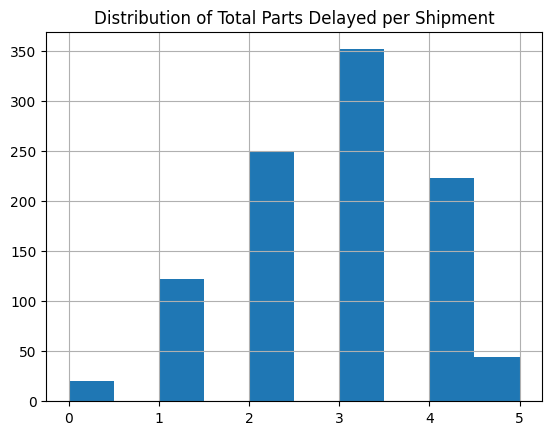

In [ ]:
# Displaying the value counts
df_class['Total_Parts_Delayed'].hist()
plt.title("Distribution of Total Parts Delayed per Shipment")
plt.show()

In [ ]:
df_class.shape

(1010, 47)

In [ ]:
# Step 11: Save the Final Dataset for Modeling
df_class.to_csv("df_cleaned_classification_final.csv", index=False)
print("Dataset saved for modeling.")

Dataset saved for modeling.


# Conclusion

The final dataset includes business-relevant engineered features and is free from leakage columns.  
It is saved as `df_cleaned_classification.csv` and ready for modeling.

This feature set reflects domain knowledge about part delays, criticality, and seasonal patterns to improve prediction accuracy.


# Classification Feature Engineering Summary

- Created binary delay flags for each critical car part based on a 2-day cutoff before scheduled assembly.
- Aggregated delay metrics include total parts delayed and count of critical parts delayed per shipment.
- Extracted temporal features (month, quarter) to capture seasonal shipment trends.
- Removed leakage and irrelevant columns such as exact delivery dates, delay days, financial impact, and delay reasons.
- Added interaction features combining order urgency and environmental factors with delays to capture complex effects.
- Prepared categorical features for encoding during modeling.
- This final dataset (1010 rows, 47 features) reflects domain knowledge and real-world constraints, providing a solid foundation for predictive classification models on shipment delay.
